# PPMI

In [26]:
rm_otlyr = function(vec, sd_thres=3){
    nmis= which(!is.na(vec)) # vector of indexes for non-missing values
    x   = vec[nmis] # non-missing x
    xm  = mean(x) # mean of x
    xsd = sd(x) # sd of x
    xul = xm + sd_thres * xsd # upper limit
    xll = xm - sd_thres * xsd # lower limit
    xoi  = ((x<xll) | (xul<x)) # boolen vector [TRUE] for outliers
    xrm = nmis[xoi] # the indexes of the outliers
    vec[xrm] = NA_real_ # give NA for outliers
    return(vec)
}

INT <- function(x){ # Inverse rank normalization transformation
    qnorm((rank(x,na.last="keep")-0.5)/sum(!is.na(x)))
}

In [27]:
library(dplyr)
library(data.table)
library(ggplot2)
library(tidyverse)

In [28]:
wkdir='/data/CARD/projects/Biomarkers'
t= fread(paste0(wkdir, '/data/Current_Biospecimen_Analysis_Results_0826.csv'))

In [4]:
t = t %>% distinct %>%
  arrange(desc(1:nrow(.))) %>% # arrange descending to get the last with distinct later
  group_by(PATNO, TYPE, TESTNAME, UNITS, CLINICAL_EVENT, PROJECTID) %>% 
  mutate(N = n()) %>% ungroup()
t %>% with(table(PROJECTID, N)) # Duplication exists

         N
PROJECTID      1      2      3      6
      104    694      0      0      0
      105   5880   1122    114      0
      106  21665      0      0      0
      112   4572      0      0      0
      113    596      0      0      0
      114   4000      0      0      0
      118 121212      0      0      0
      119  15921      0      0      0
      122   6749      0      0      0
      123   1190      0      0      0
      124   2900    170      0      0
      125   8700    510      0      0
      126   5481      0      0      0
      127      1     20      0      0
      129     55      0      0      0
      130   3768      0      0      0
      132   1562      0      0      0
      134   2900    170      0      0
      135  99968      0      0      0
      137   1194      0      0      0
      143     84      2      0      0
      144   4959      0      0      0
      145   5145      0      0      0
      152  11228      0      0      0
      153     73     24     30      6
 

In [5]:
t1 = t %>%
  distinct(PATNO, TYPE, TESTNAME, CLINICAL_EVENT, PROJECTID, .keep_all = T) %>% 
  filter(!grepl('^rs', TESTNAME)) %>% 
  filter(!grepl('rep\ 1', TESTNAME)) %>%
  filter(!grepl('SCORE', TESTNAME)) %>% 
  filter(!grepl('RNA', TYPE)) %>% 
  filter(!grepl('DNA', TYPE)) %>% 
  mutate(participant_id = paste0('PP-', PATNO)) %>%
  mutate(TEST = paste(TYPE, TESTNAME, sep= "_"))

t1 %>% distinct(PATNO, CLINICAL_EVENT, DIAGNOSIS) %>%
    with(table(DIAGNOSIS, CLINICAL_EVENT))

                  CLINICAL_EVENT
DIAGNOSIS           BL  ST U01 U02 V01 V02 V04 V05 V06 V07 V08 V09 V10 V11 V12
  Control          198   0  12   2   4 184 182   1 166   0 163   1 106   0 152
  Genetic Cohort   696   1  74   1   0 469 561   2 393   1 222   0  86   1  45
  Genetic Registry   2   0   0   0   0   0   0   0   1   0   1   0   1   0   1
  PD               425 135   9   1   4 283 360   1 358   7 355   1 234   1 309
  Prodromal         63   3   5   1   0  59  60   0  57   0  52   0  27   0  13
  SWEDD             64   3   0   0   0  44  47   0  38   0   1   0   1   0   1
                  CLINICAL_EVENT
DIAGNOSIS          V13 V14 V15 V16
  Control            3  48   3   6
  Genetic Cohort     0   0   0   0
  Genetic Registry   0   0   0   0
  PD                70  76   3   4
  Prodromal          0   0   0   0
  SWEDD              1   1   0   0

In [6]:
longOUTCOME = t1 %>% filter(CLINICAL_EVENT != "BL") %>%
  distinct(TEST) %>% t %>% as.vector

CS = t1 %>% filter(!(TEST %in% longOUTCOME)) %>%
  filter(TEST!='Cerebrospinal Fluid_Amprion-Fast-alpha-synuclein-PMCA Sample volume (Rep3)') %>% 
  ungroup
CS %>% with(table(TEST, DIAGNOSIS))
csOutcomes = CS %>% distinct(TEST) %>% t %>% as.vector

                        DIAGNOSIS
TEST                     Control Genetic Cohort  PD Prodromal SWEDD
  Serum_IgG                   99              0  99         0     0
  Serum_IgG3                  99              0  99         0     0
  Serum_IgG3/IgG              99              0  99         0     0
  Serum_PD2                   99              0  99         0     0
  Serum_PD2 Peptoid           83              0  76         0     0
  Serum_PD2 peptoid           17              0  24         0     0
  Serum_PlsEtn 16:0/18:1     188            663 396        57    62
  Serum_PlsEtn 16:0/18:2     188            663 396        57    62
  Serum_PlsEtn 16:0/20:4     188            663 396        57    62
  Serum_PlsEtn 16:0/20:5     188            663 396        57    62
  Serum_PlsEtn 16:0/22:6     188            663 396        57    62
  Serum_PlsEtn 18:0/18:1     188            663 396        57    62
  Serum_PlsEtn 18:0/18:2     188            663 396        57    62
  Serum_PlsEtn

In [7]:
dfall = fread('/data/CARD/PD/AMP-PD/Clinical/2021_v2_5release/clinical/Enrollment.csv') %>% distinct(participant_id, .keep_all=T)

gen_exist=fread('/data/CARD/PD/AMP-PD/Clinical/2021_v2_5release/wgs_gatk_joint_genotyping_samples.csv')$participant_id
allgen=dfall%>%filter(participant_id %in% gen_exist)

dim(allgen)
dim(dfall)

CS %>% filter(TESTNAME=='PlsEtn 16:0/18:1') %>% 
    left_join(., dfall, by='participant_id') %>%
     with(table(study_arm, DIAGNOSIS,useNA = 'ifany' ))


# With genetic info
CS %>% filter(TESTNAME=='PlsEtn 16:0/18:1') %>% 
    inner_join(., allgen, by='participant_id') %>%
     with(table(study_arm, DIAGNOSIS,useNA = 'ifany' ))

[1] 9712    8

[1] 10023     8

                           DIAGNOSIS
study_arm                   Control Genetic Cohort  PD Prodromal SWEDD
  Genetic Cohort PD               0            247   0         0     0
  Genetic Cohort Unaffected       0            379   0         0     0
  Healthy Control               188              0   0         0     0
  PD                              0              0 395         0     0
  Prodromal                       0              0   0        57     0
  SWEDD                           0              0   0         0    62
  <NA>                            0             37   1         0     0

                           DIAGNOSIS
study_arm                   Control Genetic Cohort  PD Prodromal SWEDD
  Genetic Cohort PD               0            240   0         0     0
  Genetic Cohort Unaffected       0            375   0         0     0
  Healthy Control               186              0   0         0     0
  PD                              0              0 389         0     0
  Prodromal                       0              0   0        57     0
  SWEDD                           0              0   0         0    62

In [8]:
t1 %>% filter(TEST %in% longOUTCOME) %>%
  inner_join(., allgen, by='participant_id') %>%
  distinct(participant_id, TEST, .keep_all=T) %>%
  group_by(TEST) %>% filter(n()>450) %>%
  ungroup %>%
  filter(!study_arm %in% c('Genetic Registry PD', 'Genetic Registry Unaffected')) %>% # remove very few
  mutate(study_arm=case_when(
      study_arm=='Genetic Cohort PD' ~ 'GENPD',
      study_arm=='Genetic Cohort Unaffected' ~ 'GENUM',
      study_arm=='Healthy Control' ~ 'HC',
      TRUE~study_arm
  ))%>%
  with(table(TEST, study_arm)) # N_individuals having data

t1 %>% filter(TEST =='Cerebrospinal Fluid_ABeta 1-42') %>%
  arrange(CLINICAL_EVENT) %>%
#   distinct(participant_id, TEST, .keep_all=T) %>%
  left_join(., allgen, by='participant_id') %>%
  with(table(study_arm, CLINICAL_EVENT))

# t1 %>% filter(TEST =='Serum_NfL') %>%
#   arrange(CLINICAL_EVENT) %>%
# #   distinct(participant_id, TEST, .keep_all=T) %>%
#   left_join(., allgen, by='participant_id') %>%
#   with(table(study_arm, CLINICAL_EVENT))

t1 %>% filter(TEST =='Whole Blood_GCase activity') %>%
  arrange(CLINICAL_EVENT) %>%
#   distinct(participant_id, TEST, .keep_all=T) %>%
  left_join(., allgen, by='participant_id') %>%
  with(table(study_arm, CLINICAL_EVENT))


                                         study_arm
TEST                                      GENPD GENUM  HC  PD Prodromal SWEDD
  Cerebrospinal Fluid_ABeta                 177   341 139 276        43     1
  Cerebrospinal Fluid_ABeta 1-42            100    82 190 409        56    62
  Cerebrospinal Fluid_ABeta raw             177   341 139 276        43     1
  Cerebrospinal Fluid_C16 Cer                 0     0 173 385         0     0
  Cerebrospinal Fluid_C16 GL2                 0     0 173 385         0     0
  Cerebrospinal Fluid_C16 GlcCer              0     0 173 385         0     0
  Cerebrospinal Fluid_C16 SM                  0     0 173 385         0     0
  Cerebrospinal Fluid_C18 Cer                 0     0 173 385         0     0
  Cerebrospinal Fluid_C18 GL2                 0     0 173 385         0     0
  Cerebrospinal Fluid_C18 GlcCer              0     0 173 385         0     0
  Cerebrospinal Fluid_C18 SM                  0     0 173 385         0     0
  Cerebrospin

                             CLINICAL_EVENT
study_arm                      BL  ST U01 V01 V02 V04 V05 V06 V07 V08
  Genetic Cohort PD            98   0   2   0   1  43   0   0   0   0
  Genetic Cohort Unaffected    82   0   0   0   0  28   0   1   0   0
  Genetic Registry PD           1   0   0   0   0   0   0   0   0   0
  Genetic Registry Unaffected   1   0   0   0   0   0   0   0   0   0
  Healthy Control             186   0   2   4 157 152   1 134   0 111
  PD                          404 129   2   4 246 300   1 287   2 225
  Prodromal                    55   1   0   0  45  36   0   3   0   0
  SWEDD                        59   3   0   0  44  47   0  38   0   1

                 CLINICAL_EVENT
study_arm          BL  ST V04 V06 V08
  Healthy Control 125   0 126 110 107
  PD              304   1 256 257 250

In [93]:
t1$PROJECTID %>% unique
#identify the same TEST name in the different projectID
t1 %>% distinct(PROJECTID, TEST) %>% group_by(TEST) %>% filter(n()>1)

[1] 182 173 172 159 158 155 153 145 152 144 143 137 135 134 132 130 129 127 125
[20] 124 123 122 113 112

PROJECTID,TEST
<int>,<chr>
159,Cerebrospinal Fluid_tTau
159,Cerebrospinal Fluid_pTau
125,Cerebrospinal Fluid_tTau
125,Cerebrospinal Fluid_pTau


In [94]:
# non convertable values in TESTVALUE columns
t1 %>% filter(TEST %in% longOUTCOME) %>%
  arrange(PROJECTID) %>%
  inner_join(., allgen, by='participant_id') %>%
  distinct(participant_id, CLINICAL_EVENT, TEST, .keep_all=T) %>% # No dups (Some overlapping samples for pTau, tTau etc)
  group_by(TEST) %>% filter(n()>450) %>%
  ungroup %>%
  mutate(study_arm_s=case_when(
      study_arm=='Genetic Cohort PD' ~ 'GENPD',
      study_arm=='Genetic Cohort Unaffected' ~ 'GENUM',
      study_arm=='Healthy Control' ~ 'HC',
      TRUE~study_arm
  ))%>%
  filter(!study_arm %in% c('Genetic Registry PD', 'Genetic Registry Unaffected')) %>% # remove very few
#   head(n=1000) %>% 
  mutate(TEST=gsub(' ', '_', TEST)) %>% 
  mutate(TEST=gsub('\'', '', TEST)) %>% 
  mutate(TEST=gsub('-', '_', TEST)) %>% 
  mutate(TEST=gsub(';', '_', TEST)) %>% 
  mutate(TEST=gsub(':', '_', TEST)) %>% 
  mutate(TEST=gsub(',', '_', TEST)) %>% 
  mutate(TEST=gsub('Cerebrospinal_Fluid', 'CSF', TEST)) %>% 
  select(participant_id, study_arm, CLINICAL_EVENT, TEST, TESTVALUE) %>% 
  mutate(val = as.numeric(TESTVALUE)) %>%
  filter(is.na(val)) %>%
  group_by(TEST, TESTVALUE) %>% mutate(N = n()) %>% distinct(TEST, TESTVALUE, N) %>% arrange(desc(N))

Warning message in mask$eval_all_mutate(quo):
"NAs introduced by coercion"


TEST,TESTVALUE,N
<chr>,<chr>,<int>
CSF_CSF_Hemoglobin,below,1747
CSF_CSF_Hemoglobin,above,287
CSF_pTau,<8,240
CSF_tTau,<80,56
CSF_IL_6,<1.5,41
CSF_ABeta_1_42,,31
CSF_S100,,5
CSF_CSF_Alpha_synuclein,N/A,4
Plasma_Triglycerides,below detection limit,3


Warning message in mask$eval_all_mutate(quo):
"NAs introduced by coercion"


                             CLINICAL_EVENT
study_arm                      BL  ST U01 V01 V02 V04 V05 V06 V07 V08
  Genetic Cohort PD            98   0   2   0   1  43   0   0   0   0
  Genetic Cohort Unaffected    82   0   0   0   0  28   0   1   0   0
  Genetic Registry PD           1   0   0   0   0   0   0   0   0   0
  Genetic Registry Unaffected   1   0   0   0   0   0   0   0   0   0
  Healthy Control             186   0   2   4 157 152   1 134   0 111
  PD                          404 129   2   4 246 300   1 287   2 225
  Prodromal                    55   1   0   0  45  36   0   3   0   0
  SWEDD                        59   3   0   0  44  47   0  38   0   1

Warning message in mask$eval_all_mutate(quo):
"NAs introduced by coercion"


                 CLINICAL_EVENT
study_arm          BL  ST U01 V01 V02 V04 V05 V06 V08 V10 V11
  Healthy Control 100   0   1   1  95  94   0  83  66  72   0
  PD              211   4   1   1 150 199   1 196 154 143   1

                 CLINICAL_EVENT
study_arm          BL  ST U01 V01 V02 V04 V05 V06 V08
  Healthy Control 100   0   1   1  95  94   0  83  66
  PD              211   4   1   1 150 199   1 196 154


Call:
lm(formula = v2 ~ v1 - 1)

Residuals:
     Min       1Q   Median       3Q      Max 
-244.493  -19.031    3.546   28.334  248.356 

Coefficients:
    Estimate Std. Error t value Pr(>|t|)    
v1 0.0707890  0.0007354   96.26   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 45.9 on 1380 degrees of freedom
  (1 observation deleted due to missingness)
Multiple R-squared:  0.8704,	Adjusted R-squared:  0.8703 
F-statistic:  9266 on 1 and 1380 DF,  p-value: < 2.2e-16


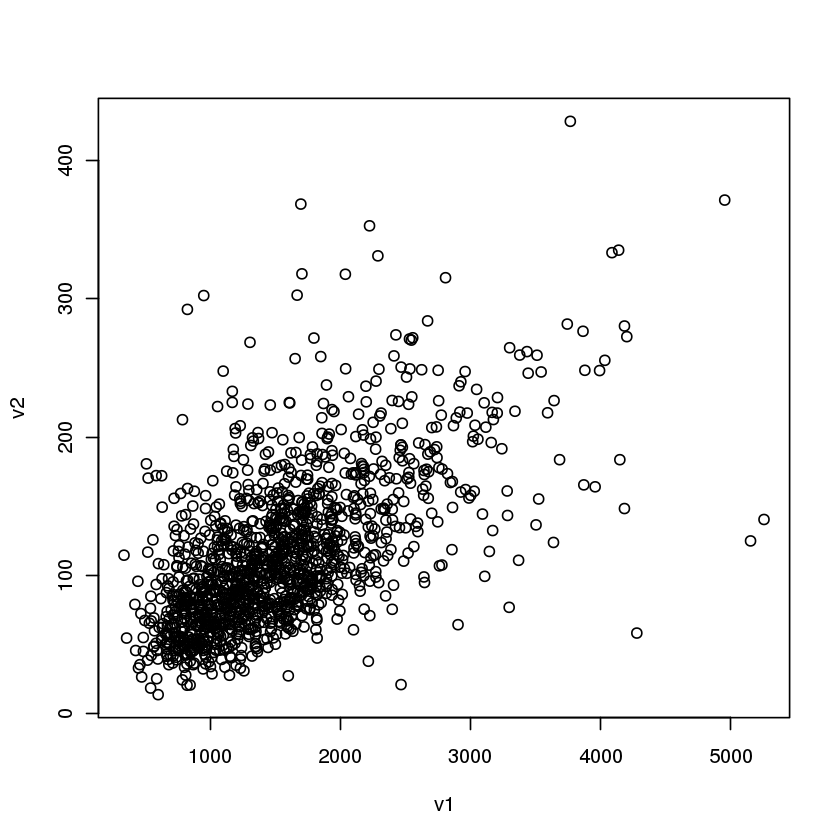

In [95]:
# it seems there are two async
a1 = t1 %>% filter(TEST=='Cerebrospinal Fluid_CSF Alpha-synuclein')  %>% 
  left_join(., allgen, by='participant_id') %>%
  mutate(v1 = as.numeric(TESTVALUE)) 
a1 %>%  with(table(study_arm, CLINICAL_EVENT))
a2 = t1 %>% filter(TEST=='Cerebrospinal Fluid_a-Synuclein')  %>% 
  left_join(., allgen, by='participant_id') %>%
  mutate(v2 = as.numeric(TESTVALUE))
a2 %>%   with(table(study_arm, CLINICAL_EVENT))
a3 = inner_join(a1, a2, by=c('participant_id', 'CLINICAL_EVENT')) %>%
  left_join(., allgen, by='participant_id')
a3 %>%   with(table(study_arm, CLINICAL_EVENT))
a3 %>% filter(v2<1500) %>% with(plot(v1, v2))
a3 %>% filter(v2<1500) %>% with(lm(v2~v1-1)) %>% summary

Warning message in mask$eval_all_mutate(quo):
"NAs introduced by coercion"


                             CLINICAL_EVENT
study_arm                      BL  ST U01 V01 V02 V04 V05 V06 V07 V08
  Genetic Cohort PD            98   0   2   0   1  43   0   0   0   0
  Genetic Cohort Unaffected    82   0   0   0   0  28   0   1   0   0
  Genetic Registry PD           1   0   0   0   0   0   0   0   0   0
  Genetic Registry Unaffected   1   0   0   0   0   0   0   0   0   0
  Healthy Control             186   0   2   4 157 152   1 134   0 111
  PD                          404 129   2   4 246 300   1 287   2 225
  Prodromal                    55   1   0   0  45  36   0   3   0   0
  SWEDD                        59   3   0   0  44  47   0  38   0   1

                           CLINICAL_EVENT
study_arm                    BL  ST U01 U02 V02 V04 V05 V06 V07 V08 V09 V10 V11
  Genetic Cohort PD         104   0   0   0   1  80   2  94   1  67   0  43   1
  Genetic Cohort Unaffected 244   0   0   1   0 238   0 181   0  94   0  41   0
  Genetic Registry PD         0   0   0   0   0   0   0   1   0   1   0   1   0
  Healthy Control             6   0   1   0   8   8   0   3   0  25   1 105   0
  PD                         15   3   3   0   7   7   0   8   0  48   0 228   1
  Prodromal                   0   2   0   0   0   9   0  33   0  33   0  27   0
  SWEDD                       0   0   0   0   0   0   0   0   0   0   0   1   0
                           CLINICAL_EVENT
study_arm                   V12 V13 V14 V15 V16
  Genetic Cohort PD          26   0   0   0   0
  Genetic Cohort Unaffected  19   0   0   0   0
  Genetic Registry PD         1   0   0   0   0
  Healthy Control           103   3  47   3   6
  PD                        185  67 

                 CLINICAL_EVENT
study_arm         BL ST V02 V04 V06 V08
  Healthy Control  6  0   8   8   3  10
  PD              15  3   7   7   8   0


Call:
lm(formula = v2 ~ v1 - 1)

Residuals:
    Min      1Q  Median      3Q     Max 
-851.70  -15.12   69.22  190.81  987.10 

Coefficients:
   Estimate Std. Error t value Pr(>|t|)    
v1  0.92446    0.03175   29.12   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 280.8 on 72 degrees of freedom
  (2 observations deleted due to missingness)
Multiple R-squared:  0.9217,	Adjusted R-squared:  0.9206 
F-statistic: 847.7 on 1 and 72 DF,  p-value: < 2.2e-16


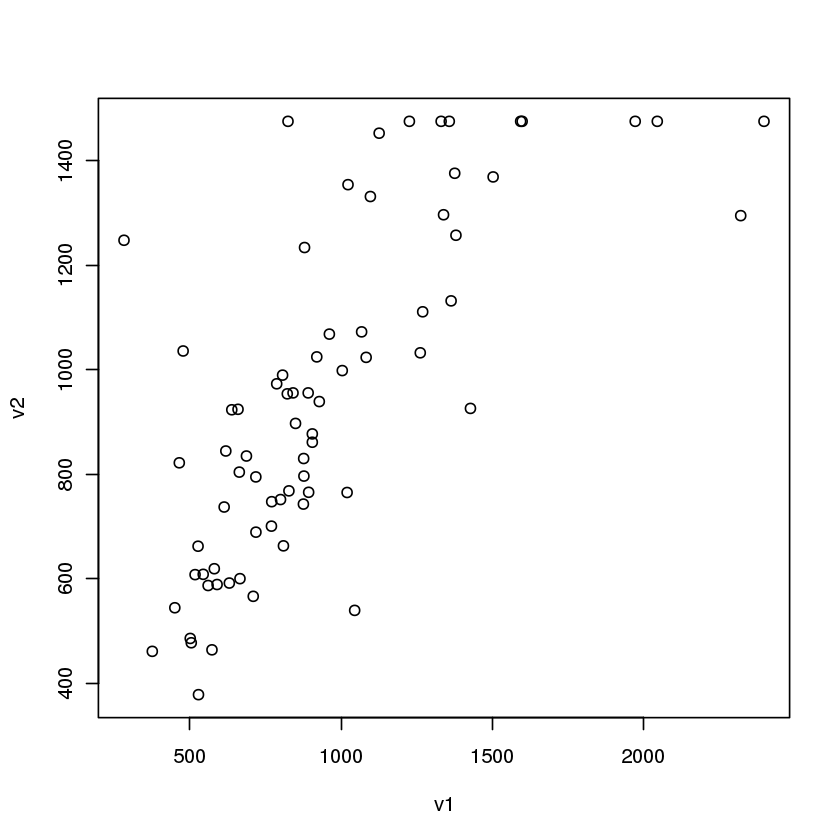

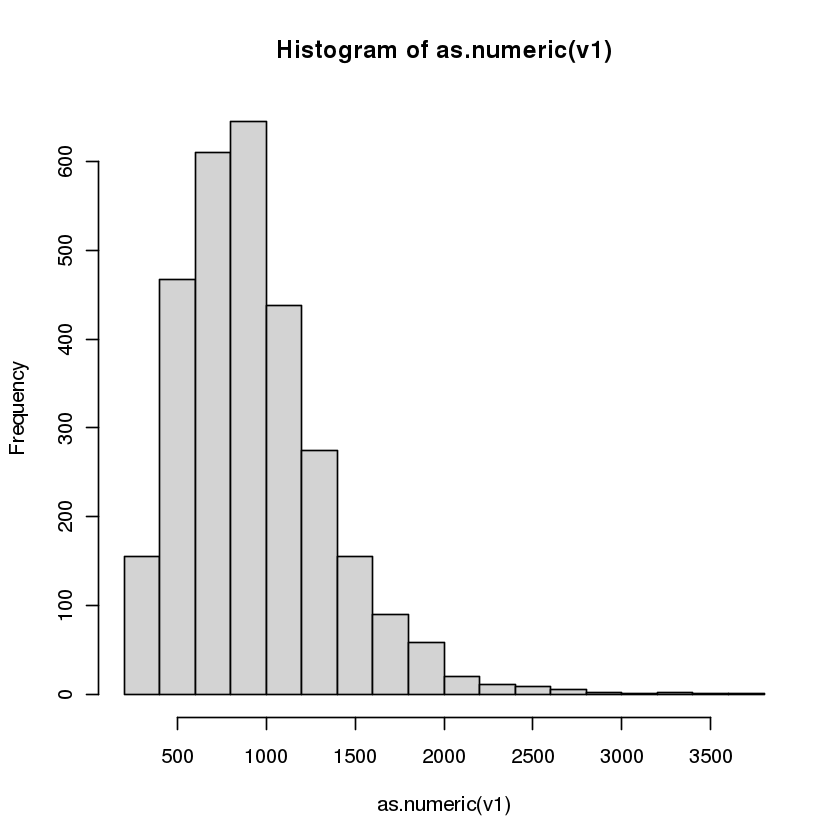

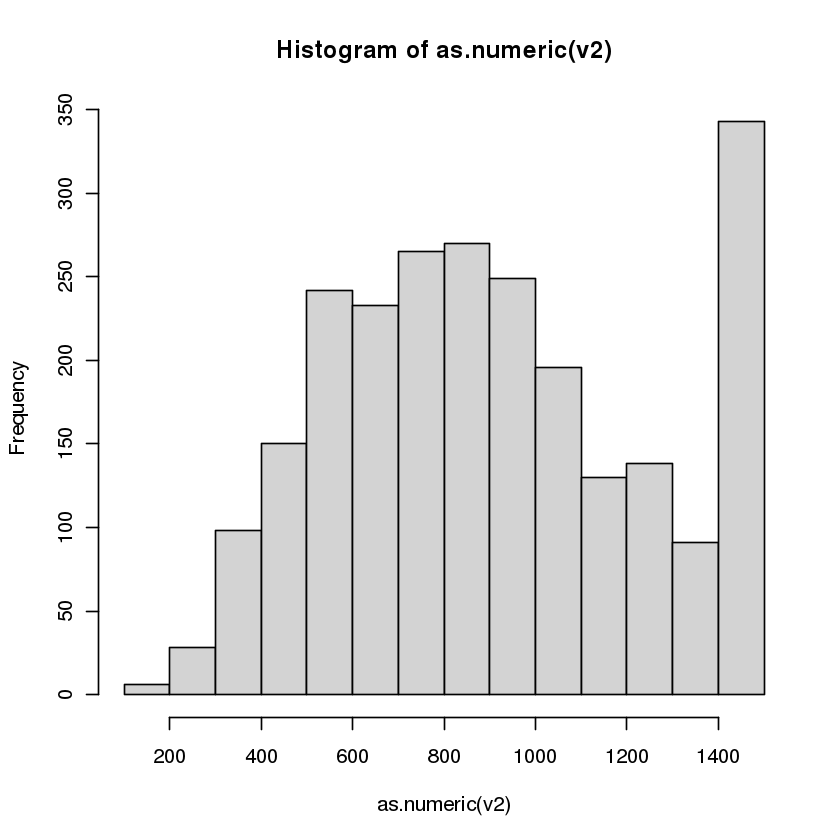

In [96]:
# Two abeta: The latter having a limited range

# it seems there are two abeta and asyn; Abeta is converted but asyn is not.
a1 = t1 %>% filter(TEST=='Cerebrospinal Fluid_ABeta 1-42')  %>% 
  left_join(., allgen, by='participant_id') %>%
  mutate(v1 = as.numeric(TESTVALUE)) 
a1 %>%  with(table(study_arm, CLINICAL_EVENT))
a2 = t1 %>% filter(TEST=='Cerebrospinal Fluid_ABeta')  %>% 
  left_join(., allgen, by='participant_id') %>%
  mutate(v2 = as.numeric(TESTVALUE))
a2 %>%   with(table(study_arm, CLINICAL_EVENT))
a3 = inner_join(a1, a2, by=c('participant_id', 'CLINICAL_EVENT')) %>%
  left_join(., allgen, by='participant_id')
a3 %>%   with(table(study_arm, CLINICAL_EVENT))
a3 %>% filter(v2<1500) %>% with(plot(v1, v2))
a3 %>% filter(v2<1500) %>% with(lm(v2~v1-1)) %>% summary

a1 %>% with(hist(as.numeric(v1)))
a2 %>% with(hist(as.numeric(v2)))

In [97]:
# CSF were measured in two batches. Have the result with the different batch information to adjust. 
tw = t1 %>% filter(TEST %in% longOUTCOME) %>%
  arrange(PROJECTID) %>%
  left_join(., allgen, by='participant_id') %>%
  filter(!study_arm %in% c('Genetic Registry PD', 'Genetic Registry Unaffected')) %>% # remove very few
  inner_join(., allgen, by='participant_id') %>%
  distinct(participant_id, CLINICAL_EVENT, TEST, .keep_all=T) %>% # No dups (Some overlapping samples for pTau, tTau etc)
  group_by(TEST) %>% filter(n()>450) %>%
  ungroup %>%
#   head(n=1000) %>% 
  mutate(TESTVALUE = case_when(
      TESTVALUE=='<8' ~ 7, # CSF pTau
      TESTVALUE=='<80' ~ 79, # CSF tTau
      TESTVALUE=='<1.5' ~ 1.4, # CSF IL-6, CSF_a_Synuclein (only 3)
      TESTVALUE=='<200' ~ 199, # CSF Abeta
      TRUE ~ as.numeric(TESTVALUE)
  )) %>%
  # change names
  mutate(TEST=gsub(' ', '_', TEST)) %>% 
  mutate(TEST=gsub('\'', '', TEST)) %>% 
  mutate(TEST=gsub('-', '_', TEST)) %>% 
  mutate(TEST=gsub(';', '_', TEST)) %>% 
  mutate(TEST=gsub(':', '_', TEST)) %>% 
  mutate(TEST=gsub(',', '_', TEST)) %>% 
  mutate(TEST=gsub('Cerebrospinal_Fluid', 'CSF', TEST)) %>% 
  select(participant_id, CLINICAL_EVENT, TEST, TESTVALUE) %>%
  # spread
  spread(TEST, TESTVALUE) %>%
  # combine CSF-Ab and make the irnt
  # Give dummy for the min, max for Abeta (Need to standardize for the newer measurement of range 200-1700)
  mutate(CSF_ABeta_dummy1 = case_when(
    is.na(CSF_ABeta_1_42) ~ NA_real_,
    CSF_ABeta_1_42 <= 200 ~ 199, # min
    CSF_ABeta_1_42 >= 1700 ~ 1701, # max
    TRUE~CSF_ABeta_1_42)) %>%
  mutate(CSF_ABeta_dummy2 = case_when(
    is.na(CSF_ABeta_raw) ~ NA_real_,
    CSF_ABeta_raw <= 200 ~ 199, # min
    CSF_ABeta_raw >= 1700 ~ 1701, # max
    TRUE ~ CSF_ABeta)) %>% 
  mutate(CSF_Ab_dummy=if_else(!is.na(CSF_ABeta_dummy1), CSF_ABeta_dummy1, CSF_ABeta_dummy2)) %>%
  mutate(CSF_Ab_irnt = INT(CSF_Ab_dummy)) %>%
  mutate(CSF_IL_6_irnt = INT(CSF_IL_6)) %>%
  # other IRNT
  mutate(CSF_IL_6_irnt = INT(CSF_IL_6)) %>%
  # Values only in measurable range ############
  # Give NA for the min, max
  mutate(CSF_Ab = case_when(
    is.na(CSF_Ab_dummy) ~ NA_real_,
    CSF_Ab_dummy <= 200 ~ NA_real_, # min
    CSF_Ab_dummy >= 1700 ~ NA_real_, # max
    TRUE~CSF_Ab_dummy)) %>%
  mutate(CSF_tTau = case_when(
    is.na(CSF_tTau) ~ NA_real_,
    CSF_tTau <= 80 ~ NA_real_, # min
    CSF_tTau >= 1300 ~ NA_real_, # max
    TRUE ~ CSF_tTau)) %>% 
  mutate(CSF_pTau = case_when(
    is.na(CSF_pTau) ~ NA_real_,
    CSF_pTau <= 8 ~ NA_real_, # min
    CSF_pTau >= 120 ~ NA_real_, # max
    TRUE ~ CSF_pTau)) %>% 
  mutate(CSF_aSyn2=ifelse(CSF_a_Synuclein<1.5, NA_real_, CSF_a_Synuclein),
         CSF_IL_6 = ifelse(CSF_IL_6_irnt<1.5, NA_real_, CSF_IL_6)) %>%
  rename(CSF_aSyn = CSF_CSF_Alpha_synuclein) %>%
  # log transformation 
  mutate(log_CSF_Ab = log(CSF_Ab),
        log_CSF_tTau = log(CSF_tTau),
        log_CSF_pTau = log(CSF_pTau),
        log_CSF_NFL = log(CSF_NFL),
        log_CSF_aSyn = log(CSF_aSyn), # use this as main (batch 1)
        log_CSF_aSyn2 = log(CSF_aSyn2), # supplementally. 
        log_Serum_NfL = log(Serum_NfL),
        log_Serum_NfL = log(Serum_NfL),
        log_Urine_total_di_22_6_BMP = log(Urine_total_di_22_6_BMP),
        log_Urine_total_di_18_1_BMP = log(Urine_total_di_18_1_BMP),
        log_Urine_2_2_di_22_6_BMP = log(Urine_2_2_di_22_6_BMP),
        log_Plasma_EGF_ELISA = log(Plasma_EGF_ELISA)) %>%
  # give project ID for different batch of CSF Ab, pTau, tTau (skipped because it won't be adjusted..)
#   mutate(pid_ab = case_when(
#       is.na(CSF_ABeta_raw) & is.na(CSF_ABeta_1_42) ~ 'pid_dummy',
#       !is.na(CSF_ABeta_raw) ~ 'p159',
#       TRUE~'p125')) %>%
  select(-CSF_ABeta) %>%
  select(-CSF_ABeta_raw) %>%
  select(-CSF_ABeta_1_42) %>%
  select(-CSF_a_Synuclein) %>%
  select(-(contains('dummy'))) 

tw[tw==-Inf] = NA_real_


# remove outliers
twtrm = tw %>% mutate_at(vars(names(tw)[3:ncol(tw)]), rm_otlyr)



dim(twtrm)

Warning message in eval_tidy(pair$rhs, env = default_env):
"NAs introduced by coercion"


[1] 6632  106

In [98]:
# visit_month from age at visit 0908
da = fread(paste0(wkdir, '/data/Age_at_visit_0908.csv')) 
dab = da %>% filter(EVENT_ID=='BL')
dasc= da %>% filter(EVENT_ID=='SC')
daf = bind_rows(dab, dasc) %>% 
    distinct(PATNO, .keep_all=T) %>% 
    rename(AGEf = AGE_AT_VISIT)
daf %>% with(table(EVENT_ID))
da = left_join(da, daf[, c('PATNO', 'AGEf')], by='PATNO') %>%
    group_by(PATNO) %>%
    mutate(visit_month=AGE_AT_VISIT - AGEf) %>%
    ungroup() %>%
    rename(CLINICAL_EVENT=EVENT_ID) %>% 
    mutate(participant_id = paste0('PP-', PATNO)) %>%
    select(participant_id, CLINICAL_EVENT, visit_month)

tw2 = left_join(twtrm, da, by=c('participant_id', 'CLINICAL_EVENT')) %>%
  filter(!is.na(visit_month)) %>%
  .[, c('participant_id', 'visit_month', names(tw)[3:ncol(tw)])]

dim(tw2)

# some dropped before BL --> Visit month 0

EVENT_ID
  BL   SC 
1594  263 

[1] 6608  106

In [99]:
fwrite(tw2, 'PPMI_outcomes.csv')

In [100]:
# # histgram of the values
# bms = bms_loop = names(tw2)[3:ncol(tw2)]

# for(bm in bms_loop){
#     x = tw2[, bm] %>% t
#     if(sd(x, na.rm=T)==0){
#             bms = setdiff(bms, bm)
#     }
# }

# # removed
# setdiff(bms_loop, bms)

# for(bm in bms){
#     x = tw2[, bm] %>% t
#     hist(x, main=bm)
# }

In [19]:
# Catecholamine? 
grep('rine', unique(t1$TEST), value=T, ignore.case = T)
t1 %>% filter(TEST =='Cerebrospinal Fluid_Adrenaline (Epinephrine)') %>%
  arrange(CLINICAL_EVENT) %>%
#   distinct(participant_id, TEST, .keep_all=T) %>%
  left_join(., allgen, by='participant_id') %>%
  with(table(study_arm, CLINICAL_EVENT))

[1] "Urine_total di-22:6-BMP"                           
[2] "Urine_total di-18:1-BMP"                           
[3] "Urine_2,2' di-22:6-BMP"                            
[4] "Cerebrospinal Fluid_Normetanephrine"               
[5] "Cerebrospinal Fluid_Noradrenaline (Norepinephrine)"
[6] "Cerebrospinal Fluid_Metanephrine"                  
[7] "Cerebrospinal Fluid_Adrenaline (Epinephrine)"

                 CLINICAL_EVENT
study_arm         BL V04 V06
  Healthy Control 55  55  55
  PD              94  94  39

# BioFIND

In [101]:
t= fread(paste0(wkdir, '/data/Biospecimen_Analysis_Results_0908.csv'))

In [102]:
t = t %>% 
  distinct %>%
  filter(!(UNITS %in% c('Stdev', 'Standard Deviation', '')))%>%
  arrange(desc(1:nrow(.))) %>% # arrange descending to get the last with distinct later
  group_by(PATNO, TYPE, TESTNAME, UNITS, CLINICAL_EVENT, PROJECTID) %>% 
  mutate(N = n()) %>% ungroup()
t %>% with(table(PROJECTID, N)) # Duplication exists

         N
PROJECTID      1      2      3
      101   3600      0      0
      102    118      0      0
      103   8126     30      0
      105   1396      8      0
      106   9284      0      0
      107    600      0      0
      109    582      0      0
      110    914      0      0
      111    457      0      0
      112 111043   1370      0
      115  47558      2      0
      117 137416      0      0
      119    369      0      9
      121  26100      0      0
      122    685      0      0
      123   3078      0      0
      124   6560      0      0
      125     16      0      0
      126  34200      0      0
      127    579      0      0
      128     80      0      0
      129    369      0      9
      130    492      0     12
      131    122      0      0
      132   3374      0      0
      134    376      0      0
      135   2702      0      0

In [103]:
t1 = t %>%
  distinct(PATNO, TYPE, TESTNAME, UNITS, CLINICAL_EVENT, PROJECTID, .keep_all = T) %>% 
  filter(!grepl('^rs', TESTNAME)) %>% 
  filter(!grepl('rep\ 1', TESTNAME)) %>%
  filter(!grepl('HUMAN', TESTNAME)) %>%  # a lot of variables 
  filter(!grepl('Unknown', TESTNAME)) %>% # Plasma - Unknonw...
  filter(!grepl(' Rep ', TESTNAME)) %>% # replication?
  filter(!grepl('RT-QuIC', TESTNAME)) %>% # not quantitative [positive, negative]
  filter(!grepl('aSyn_PMCA', TESTNAME)) %>% # not quantitative [positive, negative]
  filter(!grepl('SCORE', TESTNAME)) %>% 
  filter(!grepl('RNA', TYPE)) %>% 
  filter(!grepl('DNA', TYPE)) %>% 
  mutate(participant_id = paste0('BF-', PATNO)) %>%
  mutate(TEST = paste(TYPE, TESTNAME, sep= "_"))

In [104]:
t1 %>% 
  inner_join(., allgen, by='participant_id') %>%
  distinct(participant_id, TEST, .keep_all=T) %>%
  group_by(TEST) %>% filter(n()>150) %>%
  ungroup %>%  with(table(TEST, study_arm))


                                                         study_arm
TEST                                                      Healthy Control PD
  Cerebrospinal Fluid_AUC                                              65 92
  Cerebrospinal Fluid_Abeta1-42                                        66 92
  Cerebrospinal Fluid_Alpha Synuclein                                  66 92
  Cerebrospinal Fluid_Maximal relative fluorescence value              66 91
  Cerebrospinal Fluid_Maximum fluorescence                             65 92
  Cerebrospinal Fluid_Positive Wells                                   66 91
  Cerebrospinal Fluid_Tau                                              66 92
  Cerebrospinal Fluid_Time to 50% aggregation                          66 91
  Cerebrospinal Fluid_aSyn-PMCA                                        65 92
  Cerebrospinal Fluid_hemoglobin                                       66 92
  Cerebrospinal Fluid_p-Tau                                            66 92
  Cerebro

In [105]:
tests = c('CSF_Abeta1_42', 'CSF_Alpha_Synuclein', 'CSF_Tau', 'CSF_p_Tau')
t2 = t1 %>% 
  mutate(TEST=gsub(' ', '_', TEST)) %>% 
  mutate(TEST=gsub('\'', '', TEST)) %>% 
  mutate(TEST=gsub('-', '_', TEST)) %>% 
  mutate(TEST=gsub(';', '_', TEST)) %>% 
  mutate(TEST=gsub(':', '_', TEST)) %>% 
  mutate(TEST=gsub(',', '_', TEST)) %>% 
  mutate(TEST=gsub('Cerebrospinal_Fluid', 'CSF', TEST)) %>%
  filter(TEST %in% tests)
t2 %>%  mutate(val = as.numeric(TESTVALUE)) %>%
  filter(is.na(val)) %>%
  group_by(TEST, TESTVALUE) %>% mutate(N = n()) %>% distinct(TEST, TESTVALUE, N) %>% arrange(desc(N))

Warning message in mask$eval_all_mutate(quo):
"NAs introduced by coercion"


TESTVALUE,N,TEST
<chr>,<int>,<chr>
n/a,2,CSF_p_Tau
< 4.33,1,CSF_p_Tau
Counts<50 (56),1,CSF_Tau
below reportable range,1,CSF_Alpha_Synuclein
Counts<50 (19),1,CSF_Tau


In [110]:
tw = t2 %>% mutate(TESTVALUE = as.numeric(TESTVALUE)) %>%
  select(participant_id, TEST, TESTVALUE) %>% 
  # spread
  spread(TEST, TESTVALUE) %>% 
  rename(CSF_Ab = CSF_Abeta1_42, 
         CSF_aSyn = CSF_Alpha_Synuclein,
         CSF_pTau = CSF_p_Tau,
         CSF_tTau = CSF_Tau) %>%
  mutate(log_CSF_Ab = log(CSF_Ab),
         log_CSF_aSyn=log(CSF_aSyn),
         log_CSF_pTau=log(CSF_pTau),
         log_CSF_tTau=log(CSF_tTau)) %>%
  mutate(visit_month=0)

tw = tw[, c('participant_id', 'visit_month', names(tw)[2:(ncol(tw)-1)])]

tw[tw==-Inf] = NA_real_


# remove outliers
twtrm = tw %>% mutate_at(vars(names(tw)[3:ncol(tw)]), rm_otlyr) %>% mutate(CSF_Ab_irnt = INT(CSF_Ab)) 

dim(twtrm)

Warning message in mask$eval_all_mutate(quo):
"NAs introduced by coercion"


[1] 194  11

In [111]:
fwrite(twtrm, 'BioFIND_outcomes.csv')

# PDBP

In [30]:
library(metafor)
library(data.table)
library(tidyverse)

# get the GUID list with genetics
g=fread('/data/CARD/PD/AMP-PD/Plink/2021_v2_5release/euro_king_pca_v2.5_July2021/euro_pca.eigenvec') %>%
   rename(participant_id=IID)
gu=fread('/data/CARD/PD/AMP-PD/Clinical/2021_v2_5release/amp_pd_participants.csv')
g2 = left_join(g, gu, by='participant_id')
guids=g2$guid

In [31]:
d=fread(paste0('/data/CARD/projects/Biomarkers/data/query_result_PDBP_BioassayForm_2021-05-27T15-40-051559398067230689400.csv'))
dim(d)
dg = d[d$`PDBP_BioassayForm.Required Fields.GUID` %in% guids,]
t = dg %>% select(`Study ID`,
              `PDBP_BioassayForm.Required Fields.SiteName`,
              `PDBP_BioassayForm.Subject and Sample Information.SampCollTyp`,
              `PDBP_BioassayForm.Experiment Metadata.MolPltfmName`,
              `PDBP_BioassayForm.Analyte and Test Result.AnalyteNam`,
              `PDBP_BioassayForm.Analyte and Test Result.AnalyteConcValUoM`,
              `PDBP_BioassayForm.Required Fields.GUID`, 
              `PDBP_BioassayForm.Required Fields.VisitTypPDBP`,
              `PDBP_BioassayForm.Analyte and Test Result.AnalyteConcVal`)
names(t)=c('SID', 'Site', 'Sample', 'Platform', 'Biomarker','Unit', 'GUID', 'VisitType', 'Val')
t = t[complete.cases(t$Val)]
dim(t)

[1] 5911   50

[1] 4454    9

In [32]:
t %>% group_by(SID, Site, Sample, Platform, Biomarker, Unit) %>% mutate(Count=n()) %>% 
  distinct(SID, Site, Sample, Platform, Biomarker, Unit, Count) %>%
  arrange(SID, Biomarker)

SID,Site,Sample,Platform,Biomarker,Unit,Count
<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>
242,Brigham & Women's Hospital,Plasma,API,Total Ceramide,<82>g/ml,304
242,Brigham & Women's Hospital,Plasma,API,Total Glucosylceramide,<82>g/ml,304
242,Brigham & Women's Hospital,Plasma,API,Total Lactosylceramide,<82>g/ml,304
242,Brigham & Women's Hospital,Plasma,API,Total Sphingomyelin,<82>g/ml,304
243,Johns Hopkins University_MSBI,CSF,SpectraMax,CSF total alpha-synuclein,ng/mg,15
243,Pennsylvania State University (Hershey)_MSBI,CSF,SpectraMax,CSF total alpha-synuclein,ng/mg,17
243,UT-Southwestern Medical Center_MSBI,CSF,SpectraMax,CSF total alpha-synuclein,ng/mg,12
243,Brigham and Women's_MSBI,CSF,SpectraMax,CSF total alpha-synuclein,ng/mg,1
243,Johns Hopkins University_MSBI,Serum,SpectraMax,Peripheral total alpha-synuclein,ng/mg,67


In [74]:
tests = c("Total Ceramide", "Total Glucosylceramide", 
         'Total Lactosylceramide', 'Total Sphingomyelin')
newnames = c('Plasma_total_Ceramide', 'Plasma_total_GlcCer',
           'Plasma_total_GL2','Plasma_Total_SM')
# histgram and numbers
# for(i in 1:4){
#     test_i=test[i]
#     newname=newnames[i]
#     dt = t %>% filter(Biomarker==test_i)
#     n = dt$GUID %>% unique() %>% length()
#     nobs=dim(dt)[1]
#     dt$y = as.numeric(dt$Val)
#     if(nobs>2*n){
#       amod = 'lt'
#       da = dt %>% distinct(GUID, VisitType, .keep_all=T) %>%
#         select(y, SID, GUID, VisitType, Site)
#     }else{
#       amod = 'cs'
#       da = dt %>% distinct(GUID, .keep_all=T) %>%
#         select(y, SID, GUID, Site)
#       }
#     print(sprintf('%s: n = %1.0f / n_obs = %1.0f --> [%s] analysis', test_i, n, nobs, amod))
#     head(da)
#     hist(da$y, main=newname)
#     da$y = log(da$y)
# }


In [69]:
tw = t %>% filter(Biomarker %in% tests) %>% 
    # give participant_id
    left_join(., gu, by=c('GUID'='guid')) %>%
    # give visit_month
    mutate(visit_month=case_when(
        is.na(VisitType)~NA_real_,
        VisitType=='Baseline'~0,
        TRUE~as.numeric(sub(' months', '', VisitType)))) %>%
    distinct(participant_id, visit_month, Biomarker, Val) %>%
    spread(Biomarker, Val)

tw_no_otlyr = tw %>% 
    mutate_at(vars(names(tw)[3:ncol(tw)]), as.numeric) %>% 
    mutate_at(vars(names(tw)[3:ncol(tw)]), rm_otlyr) 
names(tw_no_otlyr)[3:ncol(tw_no_otlyr)] = newnames
tw_no_otlyr %>% summary
fwrite(tw_no_otlyr, 'PDBP_outcomes.csv')

Warning message in eval_tidy(pair$rhs, env = default_env):
"NAs introduced by coercion"


 participant_id      visit_month      Plasma_total_Ceramide Plasma_total_GlcCer
 Length:304         Min.   :  0.000   Min.   :1.870         Min.   :1.590      
 Class :character   1st Qu.:  0.000   1st Qu.:3.535         1st Qu.:3.870      
 Mode  :character   Median :  0.000   Median :4.450         Median :4.630      
                    Mean   :  8.132   Mean   :4.674         Mean   :4.842      
                    3rd Qu.:  0.000   3rd Qu.:5.718         3rd Qu.:5.710      
                    Max.   :120.000   Max.   :9.000         Max.   :9.360      
                                      NA's   :2             NA's   :3          
 Plasma_total_GL2 Plasma_Total_SM 
 Min.   :1.610    Min.   : 99.65  
 1st Qu.:3.355    1st Qu.:180.29  
 Median :4.030    Median :212.70  
 Mean   :4.306    Mean   :212.51  
 3rd Qu.:5.110    3rd Qu.:248.22  
 Max.   :8.720    Max.   :337.58  
 NA's   :1        NA's   :1       

In [73]:
df = bind_rows(fread('PPMI_outcomes.csv'), 
               fread('BioFIND_outcomes.csv'),
               fread('PDBP_outcomes.csv'))
fwrite(df, 'ampPD_outcome2.csv')

# ADNI CSF ab, tau

In [186]:
# install.packages("Hmisc")
# install.packages('/data/CARD/AD/ADNI/LONI//ADNIMERGE_0.0.1.tar.gz', repos = NULL, type = "source")
# help(package = "ADNIMERGE")

In [4]:
library(ADNIMERGE)
library(tidyverse)
library(data.table)

In [9]:
# load merged data
data(adnimerge)

In [10]:
# is RID and PTID unique 1:1 relationship? --> yes
length(unique(adnimerge$RID))
adnimerge %>% distinct(RID, PTID) %>% dim

[1] 2335

[1] 2335    2

In [11]:
# samples with wgs
wgs = fread('/data/CARD/AD/ADNI/LONI/original_wgs/ADNI.808_indiv.samples.txt', header=F)
ptids = wgs$V1
rids = adnimerge %>% filter(PTID %in% ptids) %>% with(unique(RID))

In [12]:
# Demog
length(unique(adnimerge$RID))

df_primary = adnimerge %>%
    arrange(RID,M) %>%
    distinct(RID, .keep_all=T) %>%
    mutate(primary_diagnosis=as.character(DX)) %>%
    mutate(study_arm = case_when(
        DX.bl=='CN' ~ 'ADNI_Control',
        DX.bl=='EMCI' ~ 'ADNI_EMCI',
        DX.bl=='LMCI' ~ 'ADNI_LMCI',
        DX.bl=='AD' ~ 'ADNI_AD',
    )) %>%
    rename(participant_id=PTID, age_at_baseline=AGE, sex=PTGENDER,
           education_level=PTEDUCAT, ethnicity=PTETHCAT, race=PTRACCAT, apoe4=APOE4) %>%
    select(RID, participant_id, study_arm, age_at_baseline, sex, education_level, 
           ethnicity, race, apoe4, primary_diagnosis)

df_primary %>% with(table(study_arm, primary_diagnosis, useNA='ifany'))    
dim(df_primary)

df_lastdiag= adnimerge %>% 
    filter(!is.na(DX)) %>% # some don't have DX
    arrange(RID, desc(M)) %>%
    distinct(RID, .keep_all=T) %>%
    mutate(last_diagnosis=as.character(DX), 
           visit_month_of_last_diagnosis = M) %>%
    select(RID, DX, last_diagnosis, visit_month_of_last_diagnosis)
df_lastdiag %>% with(table(DX, last_diagnosis, useNA='ifany'))    
dim(df_lastdiag)


df_changediag = left_join(adnimerge, df_primary, by='RID') %>% # join with the primary diagnosis
    inner_join(., df_lastdiag, by = c('RID','DX')) %>% # keep the DX which is the same with last diag
    arrange(RID, M) %>%
    distinct(RID, .keep_all=T)%>% # take the earliest entry for the last diag
    mutate(diagnosis_change = if_else(primary_diagnosis==last_diagnosis, 'No', 'Yes'),
          visit_month_diagnosis_change = if_else(primary_diagnosis==last_diagnosis, NA_real_, as.numeric(M))) %>%
    select(RID, diagnosis_change, visit_month_diagnosis_change)

df = left_join(df_primary, df_changediag, by='RID') %>%
    left_join(., df_lastdiag, by='RID') %>%
    select(-DX)
    

df %>% with(table(primary_diagnosis, last_diagnosis, useNA='ifany'))
dim(df)

fwrite(df, 'ADNI_demog.csv')

[1] 2335

              primary_diagnosis
study_arm       CN Dementia MCI <NA>
  ADNI_AD        0      401   1    3
  ADNI_Control 523        0   0    2
  ADNI_EMCI      2        0 402    4
  ADNI_LMCI      0        6 655    1
  <NA>         310        0   0   25

[1] 2335   10

          last_diagnosis
DX          CN Dementia MCI
  CN       777        0   0
  MCI        0        0 738
  Dementia   0      785   0

[1] 2300    4

                 last_diagnosis
primary_diagnosis  CN Dementia MCI <NA>
         CN       714       31  90    0
         Dementia   0      404   3    0
         MCI       63      350 645    0
         <NA>       0        0   0   35

[1] 2335   14

In [13]:
get_data <- function(data, yname){
    df = data
    head(df) %>% print
    df$y = data[,yname]
    mis = is.na(df$y)
    cat(sprintf('nmissing = %.0f \n', sum(mis)))
    cat(sprintf('n = %.0f \n', sum(!mis)))
    df=df[!mis,]
    print(summary(df$y))
    hist(df$y, breaks=30)
    df %>% with(table(ORIGPROT,VISCODE)) %>% print
    return(df[,c('ORIGPROT','RID', 'VISCODE', yname)])
}




Warning message in mask$eval_all_mutate(quo):
"NAs introduced by coercion"


  RID VISCODE ORIGPROT DX.bl  AGE PTGENDER ABETA
1   2      bl    ADNI1    CN 74.3     Male    NA
2   2     m06    ADNI1    CN 74.3     Male    NA
3   2     m36    ADNI1    CN 74.3     Male    NA
4   2     m60    ADNI1    CN 74.3     Male    NA
5   2     m66    ADNI1    CN 74.3     Male    NA
6   2     m72    ADNI1    CN 74.3     Male    NA
nmissing = 7585 
n = 1089 
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  203.0   579.7   796.0   879.1  1156.0  1697.0 
        VISCODE
ORIGPROT  bl m06 m108 m12 m120 m18 m24 m30 m36 m48 m60 m72 m84 m96
  ADNI1  105   1   12 107    5   1  35   1  49  52  34  23  15  11
  ADNIGO  86   0    0   0    0   0  41   0   3  18   2   0   0   0
  ADNI2  288   1    0   0    0   0 135   0   0  63   1   0   0   0
  ADNI3    0   0    0   0    0   0   0   0   0   0   0   0   0   0


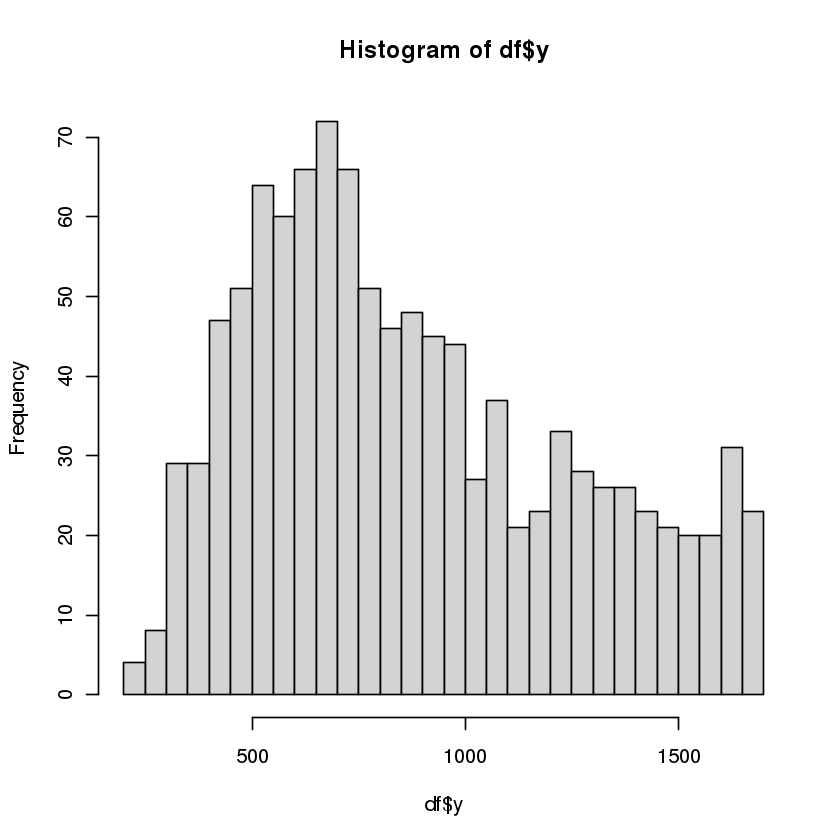

In [14]:
data = adnimerge %>% filter(RID %in% rids) %>%
  .[, c('RID', 'VISCODE', 'ORIGPROT',  'DX.bl', 'AGE', 'PTGENDER', 'ABETA')] %>% mutate(ABETA = as.numeric(ABETA))
    
t = get_data(data, 'ABETA')

In [154]:
df1 = upennbiomk_adnidian_es_2017[, c('ORIGPROT', 'RID', 'VISCODE', 'AB40', 'ABETA', 'PTAU', 'TAU')] 
df2 = upennbiomk10[, c('ORIGPROT', 'RID', 'VISCODE', 'ABETA40', 'ABETA42', 'PTAU', 'TAU')]
df3 = upennbiomk12_2020[, c('ORIGPROT', 'RID', 'VISCODE', 'AB40', 'ABETA', 'PTAU', 'TAU')]


names(df1) = c('ORIGPROT', 'RID', 'VISCODE', 'AB40', 'AB42', 'PTAU', 'TAU')
names(df2) = c('ORIGPROT', 'RID', 'VISCODE', 'AB40', 'AB42', 'PTAU', 'TAU')
names(df3) = c('ORIGPROT', 'RID', 'VISCODE', 'AB40', 'AB42', 'PTAU', 'TAU')

df1 = df1 %>% mutate_at(vars('AB40', 'AB42', 'PTAU', 'TAU'), as.numeric)%>% mutate(Batch='ADNI1GO2')
df2 = df2 %>% mutate_at(vars('AB40', 'AB42', 'PTAU', 'TAU'), as.numeric)%>% mutate(Batch='ADNI3b1')
df3 = df3 %>% mutate_at(vars('AB40', 'AB42', 'PTAU', 'TAU'), as.numeric)%>% mutate(Batch='ADNI3b2')

df = bind_rows(df1,df2,df3)
length(unique(df$RID))
dim(df)
df %>% filter(RID %in% rids) %>% with(table(ORIGPROT, VISCODE))

[1] 664

[1] 1136    8

        VISCODE
ORIGPROT  bl m108 m12 m120 m132 m144 m156 m24 m36 m48 m60 m72 m84 m96  nv
  ADNI1   11    7  12    2   12    1    4   6  10  23  18  12  13   5   2
  ADNIGO  29    3   0    0    0    0    0  24   0  10   1  10   7   7   2
  ADNI2  103    1   0    0    0    0    0  83   0  44  11  41  10  18   7
  ADNI3    0    0   0    0    0    0    0   0   0   0   0   0   0   0   0

In [175]:
# decided to use adnimerge rather than using the individual files
adnimerge %>% 
    filter(RID %in% rids) %>%
    filter(!(is.na(ABETA) & is.na(TAU) & is.na(PTAU))) %>%  # have some CSF data
    select(RID, PTID, DX.bl, DX, ABETA, TAU, PTAU, APOE4, M) %>% 
    mutate(log_CSF_Ab = log(ABETA %>% as.numeric)) %>%
    mutate(log_CSF_pTau = log(PTAU %>% as.numeric)) %>% 
    mutate(log_CSF_tTau = log(TAU %>% as.numeric)) %>% 
#     filter(is.na(log_CSF_Ab))  %>% distinct(ABETA) # >1700, <200
#     filter(is.na(log_CSF_pTau))  %>% distinct(PTAU) # <8
#     filter(is.na(log_CSF_tTau))  %>% distinct(TAU) # nothing
    mutate(t_CSF_Ab = case_when(
        ABETA=='>1700' ~ 1701,
        ABETA=='<200' ~ 199,
        TRUE ~ as.numeric(ABETA)
        )) %>%
    mutate(t_CSF_pTau = case_when(
        ABETA=='<8' ~ 7,
        TRUE ~ as.numeric(PTAU)
        )) %>%
    mutate(CSF_Ab_irnt = INT(t_CSF_Ab)) %>%
    mutate(CSF_pTau_irnt = INT(t_CSF_pTau)) %>%
    mutate(CSF_tTau_irnt = INT(log_CSF_tTau)) %>% #with(table(DX.bl, M))
    mutate(visit_month = M) %>% 
    rename(participant_id = PTID) %>% 
    select(participant_id, visit_month, 
          log_CSF_Ab, log_CSF_pTau, log_CSF_tTau, 
          CSF_Ab_irnt, CSF_pTau_irnt, CSF_tTau_irnt) %>% 
    mutate_at(vars(starts_with('log_CSF')), rm_otlyr) %>% summary
    fwrite(., 'ADNI_outcomes.csv')


# covariates
dcov = fread('ADNI_demog.csv') %>% 
    filter(RID %in% rids) %>%
    select(participant_id, age_at_baseline, sex, last_diagnosis, apoe4)
fwrite(dcov, 'ADNI_covs.csv')


Warning message in ABETA %>% as.numeric:
"NAs introduced by coercion"
Warning message in PTAU %>% as.numeric:
"NAs introduced by coercion"
Warning message in eval_tidy(pair$rhs, env = default_env):
"NAs introduced by coercion"
Warning message in eval_tidy(pair$rhs, env = default_env):
"NAs introduced by coercion"


 participant_id      visit_month       log_CSF_Ab     log_CSF_pTau  
 Length:1330        Min.   :  0.00   Min.   :5.406   Min.   :2.105  
 Class1:labelled    1st Qu.:  0.00   1st Qu.:6.366   1st Qu.:2.867  
 Class2:character   Median : 12.00   Median :6.681   Median :3.146  
 Mode  :character   Mean   : 20.49   Mean   :6.686   Mean   :3.178  
                    3rd Qu.: 36.00   3rd Qu.:7.053   3rd Qu.:3.469  
                    Max.   :120.00   Max.   :7.437   Max.   :4.500  
                                     NA's   :242     NA's   :6      
  log_CSF_tTau    CSF_Ab_irnt       CSF_pTau_irnt       CSF_tTau_irnt      
 Min.   :4.384   Min.   :-3.36972   Min.   :-3.369097   Min.   :-3.369720  
 1st Qu.:5.292   1st Qu.:-0.67390   1st Qu.:-0.673897   1st Qu.:-0.673898  
 Median :5.543   Median : 0.00000   Median : 0.000000   Median :-0.000943  
 Mean   :5.558   Mean   :-0.02098   Mean   : 0.000002   Mean   : 0.000001  
 3rd Qu.:5.819   3rd Qu.: 0.67390   3rd Qu.: 0.673897   3rd Qu.: 0.6

ERROR: Error in fwrite(., "ADNI_outcomes.csv"): object '.' not found


In [156]:
table(dcov)


      CN Dementia      MCI 
     233      246      306 

In [113]:
adnimerge %>% names

[1] "RID"                      "COLPROT"                 
  [3] "ORIGPROT"                 "PTID"                    
  [5] "SITE"                     "VISCODE"                 
  [7] "EXAMDATE"                 "DX.bl"                   
  [9] "AGE"                      "PTGENDER"                
 [11] "PTEDUCAT"                 "PTETHCAT"                
 [13] "PTRACCAT"                 "PTMARRY"                 
 [15] "APOE4"                    "FDG"                     
 [17] "PIB"                      "AV45"                    
 [19] "FBB"                      "ABETA"                   
 [21] "TAU"                      "PTAU"                    
 [23] "CDRSB"                    "ADAS11"                  
 [25] "ADAS13"                   "ADASQ4"                  
 [27] "MMSE"                     "RAVLT.immediate"         
 [29] "RAVLT.learning"           "RAVLT.forgetting"        
 [31] "RAVLT.perc.forgetting"    "LDELTOTAL"               
 [33] "DIGITSCOR"                "TRABSCOR"                
 [35] "FAQ"                      "MOCA"                    
 [37] "EcogPtMem"                "EcogPtLang"              
 [39] "EcogPtVisspat"            "EcogPtPlan"              
 [41] "EcogPtOrgan"              "EcogPtDivatt"            
 [43] "EcogPtTotal"              "EcogSPMem"               
 [45] "EcogSPLang"               "EcogSPVisspat"           
 [47] "EcogSPPlan"               "EcogSPOrgan"             
 [49] "EcogSPDivatt"             "EcogSPTotal"             
 [51] "FLDSTRENG"                "FSVERSION"               
 [53] "IMAGEUID"                 "Ventricles"              
 [55] "Hippocampus"              "WholeBrain"              
 [57] "Entorhinal"               "Fusiform"                
 [59] "MidTemp"                  "ICV"                     
 [61] "DX"                       "mPACCdigit"              
 [63] "mPACCtrailsB"             "EXAMDATE.bl"             
 [65] "CDRSB.bl"                 "ADAS11.bl"               
 [67] "ADAS13.bl"                "ADASQ4.bl"               
 [69] "MMSE.bl"                  "RAVLT.immediate.bl"      
 [71] "RAVLT.learning.bl"        "RAVLT.forgetting.bl"     
 [73] "RAVLT.perc.forgetting.bl" "LDELTOTAL.bl"            
 [75] "DIGITSCOR.bl"             "TRABSCOR.bl"             
 [77] "FAQ.bl"                   "mPACCdigit.bl"           
 [79] "mPACCtrailsB.bl"          "FLDSTRENG.bl"            
 [81] "FSVERSION.bl"             "IMAGEUID.bl"             
 [83] "Ventricles.bl"            "Hippocampus.bl"          
 [85] "WholeBrain.bl"            "Entorhinal.bl"           
 [87] "Fusiform.bl"              "MidTemp.bl"              
 [89] "ICV.bl"                   "MOCA.bl"                 
 [91] "EcogPtMem.bl"             "EcogPtLang.bl"           
 [93] "EcogPtVisspat.bl"         "EcogPtPlan.bl"           
 [95] "EcogPtOrgan.bl"           "EcogPtDivatt.bl"         
 [97] "EcogPtTotal.bl"           "EcogSPMem.bl"            
 [99] "EcogSPLang.bl"            "EcogSPVisspat.bl"        
[101] "EcogSPPlan.bl"            "EcogSPOrgan.bl"          
[103] "EcogSPDivatt.bl"          "EcogSPTotal.bl"          
[105] "ABETA.bl"                 "TAU.bl"                  
[107] "PTAU.bl"                  "FDG.bl"                  
[109] "PIB.bl"                   "AV45.bl"                 
[111] "FBB.bl"                   "Years.bl"                
[113] "Month.bl"                 "Month"                   
[115] "M"

# Alpha Synuclein
390 individuals. baseline

In [54]:
# data(neuropath)
# neuropath %>% head
data(csfalphasyn)
csfalphasyn %>% head
csfalphasyn %>% dim
csfalphasyn2 = csfalphasyn %>% 
    mutate(EXAMDATE = as.character(EXAMDATE))
t = adnimerge %>% select(RID, EXAMDATE, VISCODE) %>% 
    mutate(RID = as.numeric(RID)) %>% 
    mutate(EXAMDATE = as.character(EXAMDATE)) %>% 
    left_join(csfalphasyn2, ., by=c('RID', 'EXAMDATE')) 
table(t$VISCODE, useNA = 'ifany')

,ORIGPROT,RID,EXAMDATE,Protocol,Box,Luminex.batch.Number,Luminex.testing.Date,alpha.syn,Hemoglobin
,<fct>,<dbl>,<date>,<labelled>,<labelled>,<labelled>,<date>,<labelled>,<labelled>
1,ADNI1,3,2005-09-12,ADNI 1,Box 2,2,2012-11-27,0.53,22.711
2,ADNI1,4,2005-11-22,ADNI 1,Box 1,1,2012-11-27,0.25,0.000
3,ADNI1,5,2005-09-07,ADNI 1,Box 2,2,2012-11-27,1.92,1902.170
4,ADNI1,8,2005-09-19,ADNI 1,Box 2,2,2012-11-27,0.69,0.000
5,ADNI1,10,2005-11-10,ADNI 1,Box 2,2,2012-11-27,0.57,70.216
6,ADNI1,14,2005-11-07,ADNI 1,Box 2,2,2012-11-27,0.42,0.000


[1] 390   9


  bl <NA> 
 163  227 

In [52]:
t

ORIGPROT,RID,EXAMDATE,Protocol,Box,Luminex.batch.Number,Luminex.testing.Date,alpha.syn,Hemoglobin,VISCODE
<fct>,<dbl>,<chr>,<labelled>,<labelled>,<labelled>,<date>,<labelled>,<labelled>,<labelled>
ADNI1,3,2005-09-12,ADNI 1,Box 2,2,2012-11-27,0.53,22.711000,bl
ADNI1,4,2005-11-22,ADNI 1,Box 1,1,2012-11-27,0.25,0.000000,NA
ADNI1,5,2005-09-07,ADNI 1,Box 2,2,2012-11-27,1.92,1902.169847,bl
ADNI1,8,2005-09-19,ADNI 1,Box 2,2,2012-11-27,0.69,0.000000,bl
ADNI1,10,2005-11-10,ADNI 1,Box 2,2,2012-11-27,0.57,70.216000,bl
ADNI1,14,2005-11-07,ADNI 1,Box 2,2,2012-11-27,0.42,0.000000,NA
ADNI1,16,2005-10-13,ADNI 1,Box 2,2,2012-11-27,0.24,31.318935,bl
ADNI1,19,2005-11-23,ADNI 1,Box 3,3,2012-11-28,0.48,192.058000,bl
ADNI1,22,2005-10-19,ADNI 1,Box 2,2,2012-11-27,0.49,9.468533,bl


In [41]:
unique(csfalphasyn$RID) %>% length

[1] 390

In [15]:
describe(neuropath)

neuropath 

 148  Variables      81  Observations
--------------------------------------------------------------------------------
ORIGPROT 
       n  missing distinct 
      81        0        2 
                      
Value      ADNI1 ADNI2
Frequency     55    26
Proportion 0.679 0.321
--------------------------------------------------------------------------------
RID 
       n  missing distinct     Info     Mean      Gmd      .05      .10 
      81        0       81        1     1961     2016       91      183 
     .25      .50      .75      .90      .95 
     487      978     4263     4910     5017 

lowest :    8   42   53   78   91, highest: 5017 5058 5079 5087 5218
--------------------------------------------------------------------------------
NPFORMMO 
       n  missing distinct     Info     Mean      Gmd      .05      .10 
      81        0       12     0.99    6.247    3.579        1        2 
     .25      .50      .75      .90      .95 
       4        6        9       1

## NFL data

  ORIGPROT RID VISCODE USERDATE EXAMDATE  VOLUME CSFNFL COMMENTS
1    ADNI1   3      bl     <NA>     <NA> 0.50 ML   2641         
2    ADNI1   4      bl     <NA>     <NA> 0.50 ML    602         
3    ADNI1   5      bl     <NA>     <NA> 0.50 ML    951         
4    ADNI1   8      bl     <NA>     <NA> 0.50 ML   1382         
5    ADNI1  10      bl     <NA>     <NA> 0.50 ML   1088         
6    ADNI1  14      bl     <NA>     <NA> 0.50 ML   1288         
nmissing = 0 
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  405.0   967.8  1250.5  1469.0  1648.2 12647.0 
        VISCODE
ORIGPROT  bl
  ADNI1  416
  ADNIGO   0
  ADNI2    0
  ADNI3    0


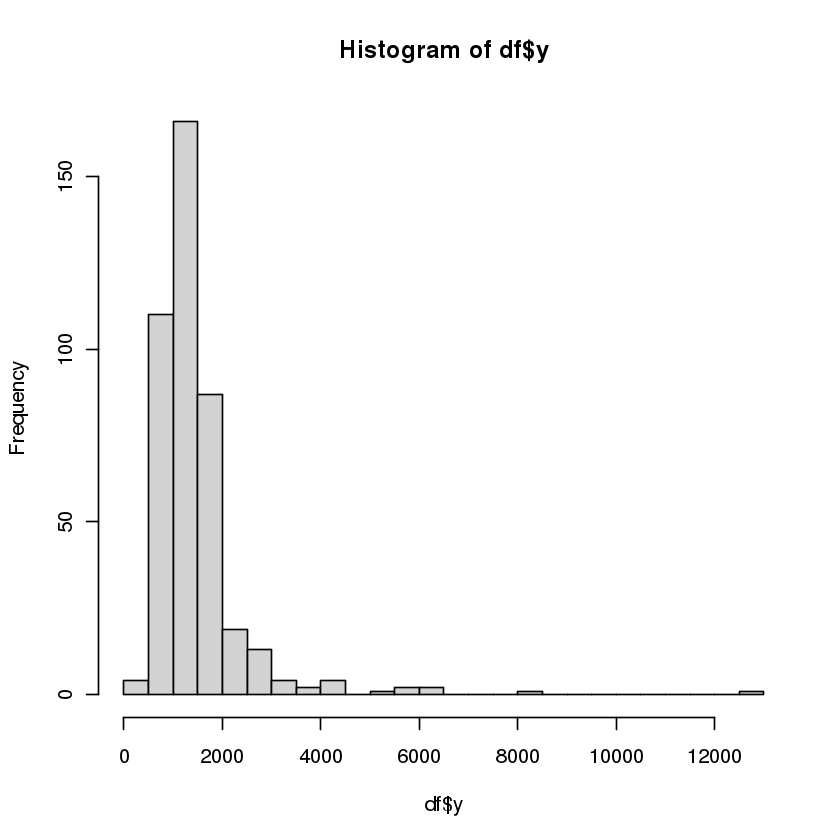

In [4]:
df = data(blennowcsfnfl)
yname='CSFNFL'



d1 = get_data(blennowcsfnfl, 'CSFNFL')

  ORIGPROT RID VISCODE   EXAMDATE BOX_POS     VOL PLASMA_NFL COMMENTS
1    ADNI1   2      bl 2005-09-08    1-21 0.50 ML       28.2         
2    ADNI1   3      bl 2005-09-12    1-22 0.50 ML      188.3         
3    ADNI1   4      bl 2005-11-08    1-09 0.50 ML       31.2         
4    ADNI1   5      bl 2005-09-07    1-20 0.50 ML       36.3         
5    ADNI1   6      bl 2005-11-29    1-03 0.50 ML       52.5         
6    ADNI1   7      bl 2005-10-06    1-24 0.50 ML       60.0         
nmissing = 4 
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   5.20   26.30   36.95   42.92   50.60  250.80 
        VISCODE
ORIGPROT      bl  sc
  ADNI1    1 576   1
  ADNIGO   0   0   0
  ADNI2    0   0   0
  ADNI3    0   0   0


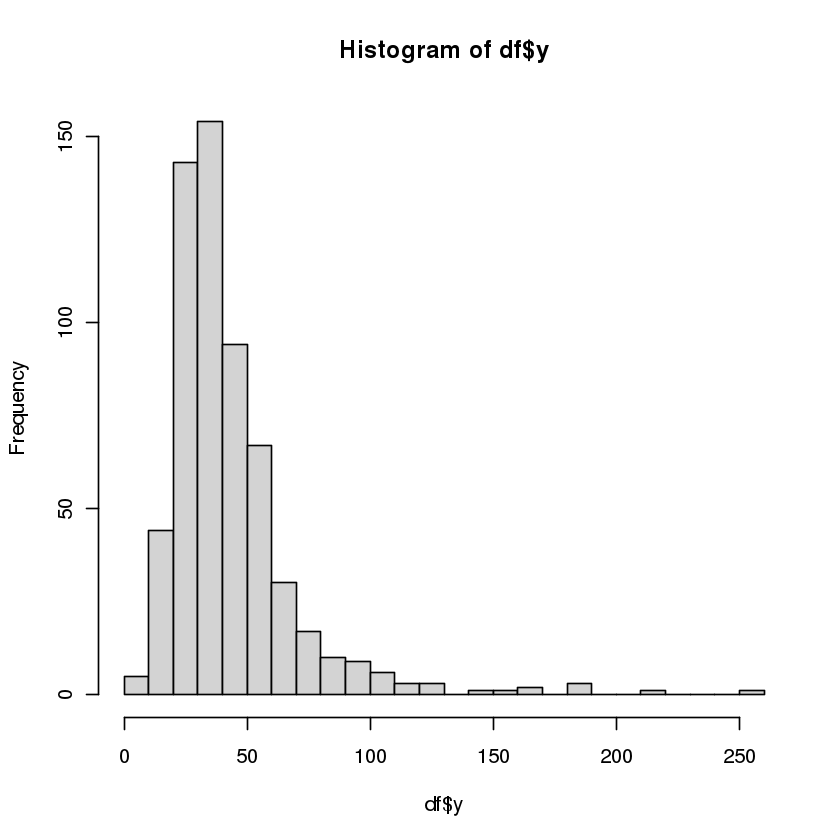

In [5]:
data(blennowplasmanfl)
yname='PLASMA_NFL'
d2 = get_data(blennowplasmanfl, yname)

  ORIGPROT RID VISCODE   USERDATE   EXAMDATE RECNO  DRAW.DATE   DRAW.TIME
1    ADNI1   2     m60 2018-09-09 2010-09-22     1 09/22/2010 09:16:00.00
2    ADNI1   2     m72 2018-09-09 2011-09-19     1 09/19/2011 09:23:00.00
3    ADNI1   2     m84 2018-09-09 2012-09-26     1 09/26/2012 08:40:00.00
4    ADNI1   2     m96 2018-09-09 2013-09-09     1 09/09/2013 09:44:00.00
5    ADNI1   8     m60 2018-09-09 2010-09-27     1 09/27/2010 11:16:00.00
6    ADNI1   8     m72 2018-09-09 2011-09-27     1 09/27/2011 09:17:00.00
  PLASMA_NFL COMMENT
1       25.3        
2       30.9        
3       34.1        
4       35.3        
5      196.3        
6       81.9        
nmissing = 1 
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   6.40   27.70   37.90   44.08   52.30  451.00 
        VISCODE
ORIGPROT  bl m06 m108 m12 m120 m24 m36 m48 m60 m72 m84 m96  nv  sc scmri
  ADNI1    0   1   37   9    5   3  14 154 201 214 175 118   2   1     0
  ADNIGO 121   0    0 117    0 104 103  64   0   0   0   0   

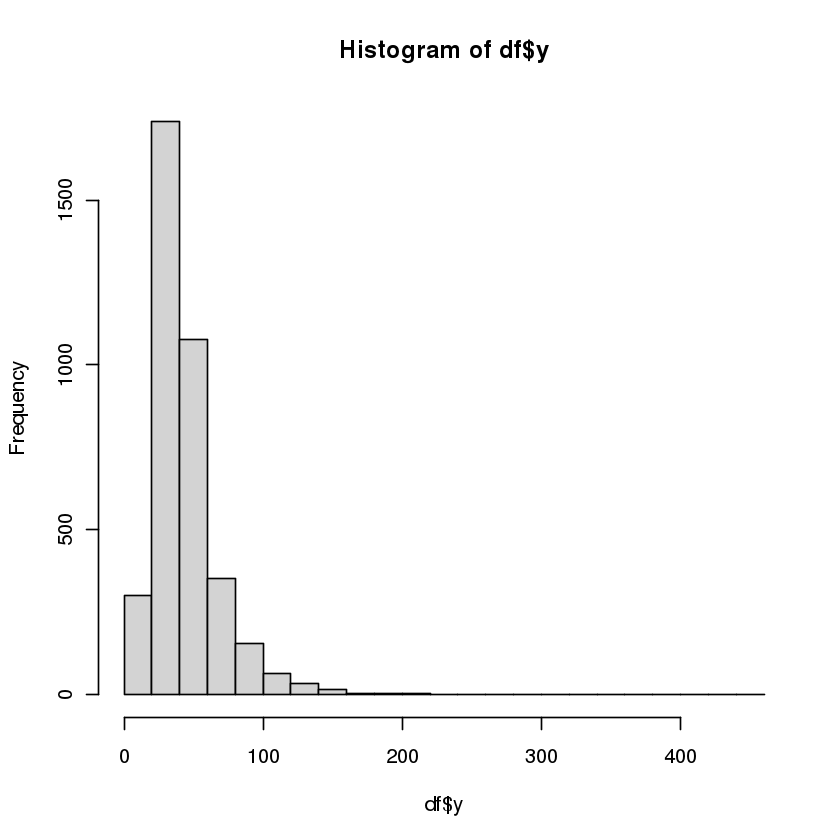

In [6]:
data(blennowplasmanfllong)
yname='PLASMA_NFL'
d3 = get_data(blennowplasmanfllong, yname)